# Выбор локации для скважины

Нужно решить, где бурить новую скважину.

У нас есть пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Нужно построить модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализировать возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

Условия задачи:
Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
Бюджет на разработку скважин в регионе — 10 млрд рублей.
При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.


## Загрузка и подготовка данных

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler

In [3]:
data_0 = pd.read_csv('/datasets/geo_data_0.csv')
data_1 = pd.read_csv('/datasets/geo_data_1.csv')
data_2 = pd.read_csv('/datasets/geo_data_2.csv')

In [4]:
data_0.info()
data_0.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


In [5]:
data_1.info()
data_1.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


In [6]:
data_2.info()
data_2.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


In [7]:
# Проверим на всякий случай есть ли в данных дубликаты
data_0.duplicated().sum()

0

In [8]:
data_1.duplicated().sum()

0

In [9]:
data_2.duplicated().sum()

0

Проверка данных на мультиколлинеарность

<AxesSubplot:>

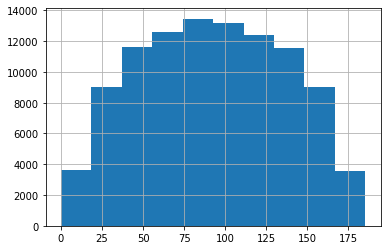

In [10]:
data_0['product'].hist()

<AxesSubplot:>

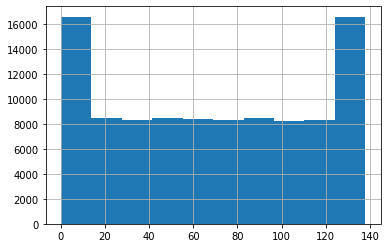

In [11]:
data_1['product'].hist()

<AxesSubplot:>

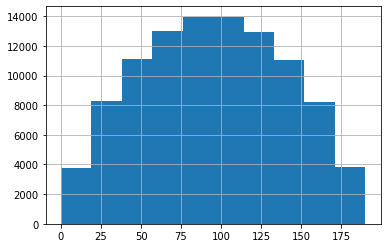

In [12]:
data_2['product'].hist()

Самое интересное распределение в регионе №2 - чаще всего встречаются значения с минимальным и максимальным значением целевого признака

<AxesSubplot:>

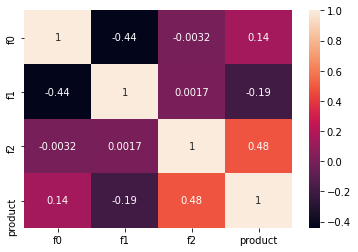

In [13]:
sns.heatmap(data_0.corr(), annot = True)

<AxesSubplot:>

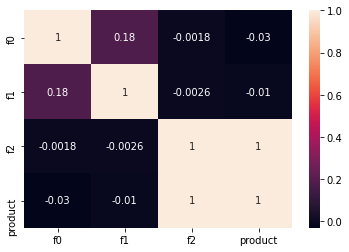

In [14]:
sns.heatmap(data_1.corr(), annot = True)

<AxesSubplot:>

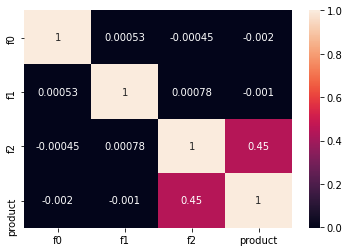

In [15]:
sns.heatmap(data_2.corr(), annot = True)

В регионе 2 наблюдаем сильную корреляцию между признаком f2 и целевым признаком product

Во всех 3 датасетах есть столбец id, который не дает никакой информации. Удалим этот столбец везде

In [16]:
data_0 = data_0.drop(['id'], axis=1)

In [17]:
data_1 = data_1.drop(['id'], axis=1)

In [18]:
data_2 = data_2.drop(['id'], axis=1)

## Обучение и проверка модели

In [19]:
state = np.random.RandomState(12345)

In [20]:
# Данные для 1 региона
features_0 = data_0.drop(['product'], axis=1)
target_0 = data_0['product']

In [21]:
features_train_0, features_valid_0, target_train_0, target_valid_0 = \
train_test_split(features_0, target_0, test_size=0.25, random_state=state)

In [22]:
# Обучим модель с помощью линейной регрессии
model = LinearRegression() 
model.fit(features_train_0, target_train_0)
predictions_valid_0 = model.predict(features_valid_0) 
result_0 = mean_squared_error(target_valid_0, predictions_valid_0)**0.5 
print("RMSE модели линейной регрессии на валидационной выборке:", result_0)
print("Средний запас сырья в 1 регионе:", target_0.mean())

RMSE модели линейной регрессии на валидационной выборке: 37.5794217150813
Средний запас сырья в 1 регионе: 92.50000000000001


In [23]:
# Данные для 2 региона
features_1 = data_1.drop(['product'], axis=1)
target_1 = data_1['product']

In [24]:
features_train_1, features_valid_1, target_train_1, target_valid_1 = \
train_test_split(features_1, target_1, test_size=0.25, random_state=state)

In [25]:
# Обучим модель с помощью линейной регрессии
model = LinearRegression() 
model.fit(features_train_1, target_train_1)
predictions_valid_1 = model.predict(features_valid_1) 
result_1 = mean_squared_error(target_valid_1, predictions_valid_1)**0.5 
print("RMSE модели линейной регрессии на валидационной выборке:", result_1)
print("Средний запас сырья во 2 регионе:", target_1.mean())

RMSE модели линейной регрессии на валидационной выборке: 0.889736773768065
Средний запас сырья во 2 регионе: 68.82500000000002


In [26]:
# Данные для 3 региона
features_2 = data_2.drop(['product'], axis=1)
target_2 = data_2['product']

In [27]:
features_train_2, features_valid_2, target_train_2, target_valid_2 = \
train_test_split(features_2, target_2, test_size=0.25, random_state=state)

In [28]:
# Обучим модель с помощью линейной регрессии
model = LinearRegression() 
model.fit(features_train_2, target_train_2)
predictions_valid_2 = model.predict(features_valid_2) 
result_2 = mean_squared_error(target_valid_2, predictions_valid_2)**0.5 
print("RMSE модели линейной регрессии на валидационной выборке:", result_2)
print("Средний запас сырья в 3 регионе:", target_2.mean())

RMSE модели линейной регрессии на валидационной выборке: 39.958042459521614
Средний запас сырья в 3 регионе: 95.00000000000004


Получили первые данные по 3 регионам. В 1 и 3 регионах прогнозы по сырью почти одинаковы и выше, чем во 2 регионе. Корни из средней квадратичной ошибки в 1 и 3 регионах тоже отличаются не сильно, чего не скажешь о 2 регионе, здесь ошибка получилась очень маленькая.

## Подготовка к расчёту прибыли

In [29]:
# Сохраним все ключевые значения в переменных 
BUDGET_200 = 10e9 # Бюджет для разработки 200 скважин
BUDGET = 10e9 / 200 # Бюджет для разработки 1 скважины
BAR_COST = 450000 # Доход с каждой единицы (1000 баррелей) продукта


In [30]:
# Рассчитаем достаточный объем сырья для безубыточной работы скважины
enough_volume = BUDGET / BAR_COST
print("Достаточный объем сырья для безубыточной работы скважины:", enough_volume)

Достаточный объем сырья для безубыточной работы скважины: 111.11111111111111


Неоьходимый нам объем сырья в 1 скважине приблизительно равен 111 тыс баррелей. Пока что средние значения для каждого региона меньше этой цифры, максимальное среднее значение в регионе №3, оно составляет 95 тыс баррелей.

## Расчёт прибыли и рисков 

In [31]:
def revenue(target, probabilities, count):
    probs_sorted = probabilities.sort_values(ascending=False) 
    selected = target[probs_sorted.index][:count] 
    return BAR_COST * selected.sum() - BUDGET_200

In [32]:
# Расчет прибыли для 1 региона
predictions_valid_0 = pd.Series(predictions_valid_0, index=target_valid_0.index)
res = revenue(target_valid_0, predictions_valid_0, 200)
print(res)

3320826043.1398506


In [33]:
# Расчет прибыли для 2 региона
predictions_valid_1 = pd.Series(predictions_valid_1, index=target_valid_1.index)
res = revenue(target_valid_1, predictions_valid_1, 200)
print(res)

2415086696.681511


In [34]:
# Расчет прибыли для 3 региона
predictions_valid_2 = pd.Series(predictions_valid_2, index=target_valid_2.index)
res = revenue(target_valid_2, predictions_valid_2, 200)
print(res)

2539915945.842947


In [35]:
# Средняя прибыль, 95%-й доверительный интервал и риск убытков - регион 1
values = []
risk = []
for i in range(1000):
    target_subsample = target_valid_0.sample(500, replace=True, random_state=state)
    probs_subsample = predictions_valid_0[target_subsample.index] 
    
    values.append(revenue(target_subsample, probs_subsample, 200))
    if revenue(target_subsample, probs_subsample, 200) < 0:
        risk.append(revenue(target_subsample, probs_subsample, 200))
risk_prop = len(risk) / len(values)

values = pd.Series(values)
lower = values.quantile(0.025)
upper = values.quantile(0.975)
mean = values.mean()

print(values.head(5))
print("Средняя выручка:", mean)
print("2,5% нижний квантиль:", lower)
print("2,5% верхний квантиль:", upper)
print("Риск убытков:", risk_prop)

0    4.056056e+08
1    4.977058e+08
2    4.555309e+08
3    2.007743e+08
4    4.310854e+08
dtype: float64
Средняя выручка: 423897237.91690534
2,5% нижний квантиль: -76187813.89036272
2,5% верхний квантиль: 957846531.951783
Риск убытков: 0.048


In [36]:
# Средняя прибыль, 95%-й доверительный интервал и риск убытков - регион 2
values = []
risk = []
for i in range(1000):
    target_subsample = target_valid_1.sample(500, replace=True, random_state=state)
    probs_subsample = predictions_valid_1[target_subsample.index] 
    
    values.append(revenue(target_subsample, probs_subsample, 200))
    if revenue(target_subsample, probs_subsample, 200) < 0:
        risk.append(revenue(target_subsample, probs_subsample, 200))
risk_prop = len(risk) / len(values)

values = pd.Series(values)
lower = values.quantile(0.025)
upper = values.quantile(0.975)
mean = values.mean()

print(values.head(5))
print("Средняя выручка:", mean)
print("2,5% нижний квантиль:", lower)
print("2,5% верхний квантиль:", upper)
print("Риск убытков:", risk_prop)

0    3.842621e+08
1    6.318661e+07
2    1.158339e+09
3    7.238732e+08
4    7.503082e+08
dtype: float64
Средняя выручка: 513256698.9172609
2,5% нижний квантиль: 108066895.23396212
2,5% верхний квантиль: 928574439.2324963
Риск убытков: 0.006


In [38]:
# Средняя прибыль, 95%-й доверительный интервал и риск убытков - регион 3
values = []
risk = []
for i in range(1000):
    target_subsample = target_valid_2.sample(500, replace=True, random_state=state)
    probs_subsample = predictions_valid_2[target_subsample.index] 
    
    values.append(revenue(target_subsample, probs_subsample, 200))
    if revenue(target_subsample, probs_subsample, 200) < 0:
        risk.append(revenue(target_subsample, probs_subsample, 200))
risk_prop = len(risk) / len(values)

values = pd.Series(values)
lower = values.quantile(0.025)
upper = values.quantile(0.975)
mean = values.mean()

print(values.head(5))
print("Средняя выручка:", mean)
print("2,5% нижний квантиль:", lower)
print("2,5% верхний квантиль:", upper)
print("Риск убытков:", risk_prop)

0    1.551682e+07
1    2.136674e+08
2    7.243272e+08
3    2.526721e+08
4    3.676756e+08
dtype: float64
Средняя выручка: 381120359.57590145
2,5% нижний квантиль: -142800630.08786878
2,5% верхний квантиль: 893380565.7504003
Риск убытков: 0.074


Лучший прогноз по прибыли показал регион №1, у него самые высокие значения. Далее идет регион №3 и сразу следом - регион №2. При этом техника Bootstrap с 1000 выборок показала, что лучшая средняя выручка и наименьшие риски у региона № 2 - более 500 млн, а риск уйти в минус - всего около 0,5%. Доверимся Bootstrap и предложим к разработке регион №2. 